# WM-811K Wafer Map Data Exploration

This notebook explores the WM-811K wafer map dataset using Polars for efficient data analysis.

The WM-811K dataset contains wafer maps from semiconductor manufacturing with labeled defect patterns.

In [ ]:
%load_ext autoreload
%autoreload 2


## 1. Import Libraries

In [ ]:
# Import libraries
import pickle
import numpy as np
from pathlib import Path
import sys

import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
# Imports the pdist function from scipy, 
# which computes pairwise distances between observations in a given array.
from scipy.spatial.distance import pdist

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Dataset

In [ ]:
# Load the pickle file (with compatibility fix for old pandas versions)
import pandas.core.indexes as indexes

# Create alias for old pandas module structure
sys.modules['pandas.indexes'] = indexes

data_path = Path.home() / "Schreibtisch/projects/data/wm811k/LSWMD.pkl"
print(f"Loading data from: {data_path}")

# Load with latin1 encoding for old pickle files
with open(data_path, 'rb') as f:
    data = pickle.load(f, encoding='latin1')

print(f"\nData type: {type(data)}")
print(f"Shape: {data.shape}")
print(f"Columns: {list(data.columns)}")

Loading data from: /home/hasan/Schreibtisch/projects/data/wm811k/LSWMD.pkl

Data type: <class 'pandas.core.frame.DataFrame'>
Shape: (811457, 6)
Columns: ['waferMap', 'dieSize', 'lotName', 'waferIndex', 'trianTestLabel', 'failureType']


## 3. Initial Data Exploration

In [ ]:
# Display first few rows
print("First 5 rows of the dataset:")
data.head()

First 5 rows of the dataset:


,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [ ]:
# Dataset info
print("Dataset Info:")
data.info()

print("\nBasic statistics (numeric columns):")
data[['dieSize', 'waferIndex']].describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB

Basic statistics (numeric columns):


,dieSize,waferIndex
count,811457.000000,811457.000000
mean,1840.998585,12.961207
std,2254.987374,7.207489
min,3.000000,1.000000
25%,710.000000,7.000000
50%,953.000000,13.000000
75%,1902.000000,19.000000
max,48099.000000,25.000000


In [ ]:
# Check for missing values
print("Missing Values:")
print(data.isnull().sum())

Missing Values:
waferMap          0
dieSize           0
lotName           0
waferIndex        0
trianTestLabel    0
failureType       0
dtype: int64


## 4. Clean Failure Type Data

The failureType column contains nested numpy arrays that need to be extracted.

In [ ]:
# Examine the structure of failureType
print("Sample failureType values:")
for i in range(5):
    val = data['failureType'].iloc[i]
    print(f"{i}: Type={type(val)}, Value={val}")

Sample failureType values:
0: Type=<class 'numpy.ndarray'>, Value=[['none']]
1: Type=<class 'numpy.ndarray'>, Value=[['none']]
2: Type=<class 'numpy.ndarray'>, Value=[['none']]
3: Type=<class 'numpy.ndarray'>, Value=[['none']]
4: Type=<class 'numpy.ndarray'>, Value=[['none']]


In [ ]:
# Extract failure types from numpy arrays
def extract_failure_type(x):
    if isinstance(x, np.ndarray):
        # Flatten the array and get the first element
        flat = x.flatten()
        if len(flat) > 0:
            return flat[0]
        else:
            return 'none'
    elif isinstance(x, list):
        while isinstance(x, list) and len(x) > 0:
            x = x[0]
        return str(x) if x else 'none'
    else:
        return str(x) if x else 'none'

data['failureType_clean'] = data['failureType'].apply(extract_failure_type)

print("Cleaned Failure Type Distribution:")
failure_counts = data['failureType_clean'].value_counts()
print(failure_counts)
print(f"\nTotal unique failure types: {len(failure_counts)}")

Cleaned Failure Type Distribution:
failureType_clean
none         785938
Edge-Ring      9680
Edge-Loc       5189
Center         4294
Loc            3593
Scratch        1193
Random          866
Donut           555
Near-full       149
Name: count, dtype: int64

Total unique failure types: 9


In [ ]:
# Show percentages
print("Failure Type Percentages:")
print((failure_counts / len(data) * 100).round(2))

Failure Type Percentages:
failureType_clean
none         96.86
Edge-Ring     1.19
Edge-Loc      0.64
Center        0.53
Loc           0.44
Scratch       0.15
Random        0.11
Donut         0.07
Near-full     0.02
Name: count, dtype: float64


## 5. Visualize Failure Type Distribution

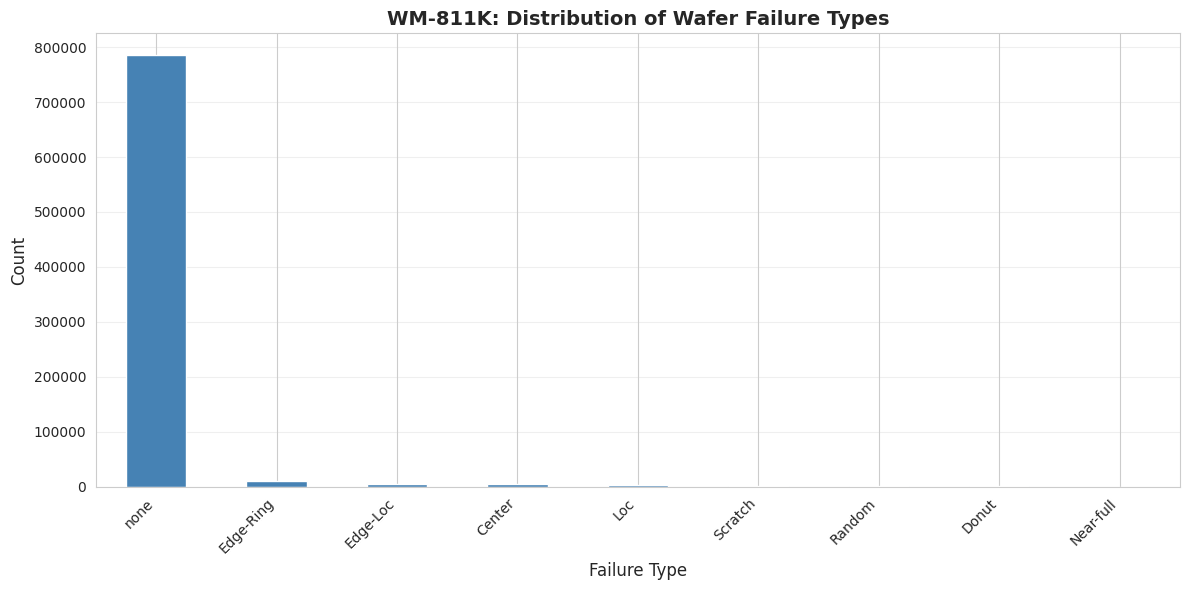


Key Insights:
- Dataset has 811,457 wafer maps
- 96.86% of wafers have no defects ('none')
- 8 distinct defect patterns identified
- Most common defect: Edge-Ring (1.19%)
- Rarest defect: Near-full (0.02%)


In [ ]:
# Visualize failure type distribution
plt.figure(figsize=(12, 6))
failure_counts.plot(kind='bar', color='steelblue')
plt.xlabel('Failure Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('WM-811K: Distribution of Wafer Failure Types', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nKey Insights:")
print(f"- Dataset has {len(data):,} wafer maps")
print(f"- {(failure_counts['none'] / len(data) * 100):.2f}% of wafers have no defects ('none')")
print(f"- {len(failure_counts) - 1} distinct defect patterns identified")
defects_only = failure_counts[failure_counts.index != 'none']
if len(defects_only) > 0:
    print(f"- Most common defect: {defects_only.index[0]} ({defects_only.iloc[0] / len(data) * 100:.2f}%)")
    print(f"- Rarest defect: {defects_only.index[-1]} ({defects_only.iloc[-1] / len(data) * 100:.2f}%)")

## 6. Visualize Sample Wafer Maps

Let's look at actual wafer maps for each defect type.

<matplotlib.image.AxesImage>

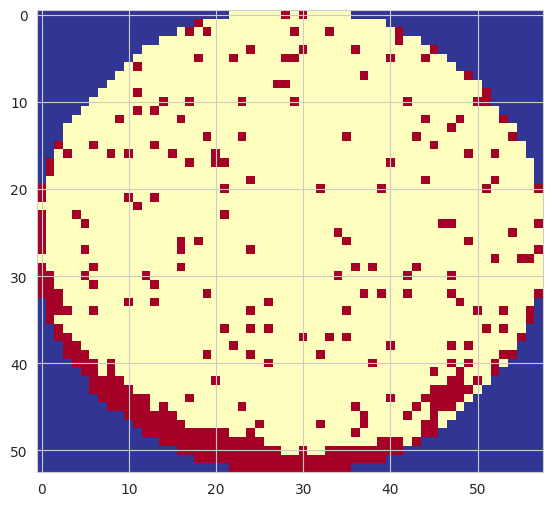

In [ ]:
query_defect = "Edge-Ring"

sample_data = data.query('failureType_clean == @query_defect').loc[:,'waferMap'].values
sample_wafer_map = sample_data[0]
plt.imshow(sample_wafer_map, cmap='RdYlBu_r', interpolation='nearest')

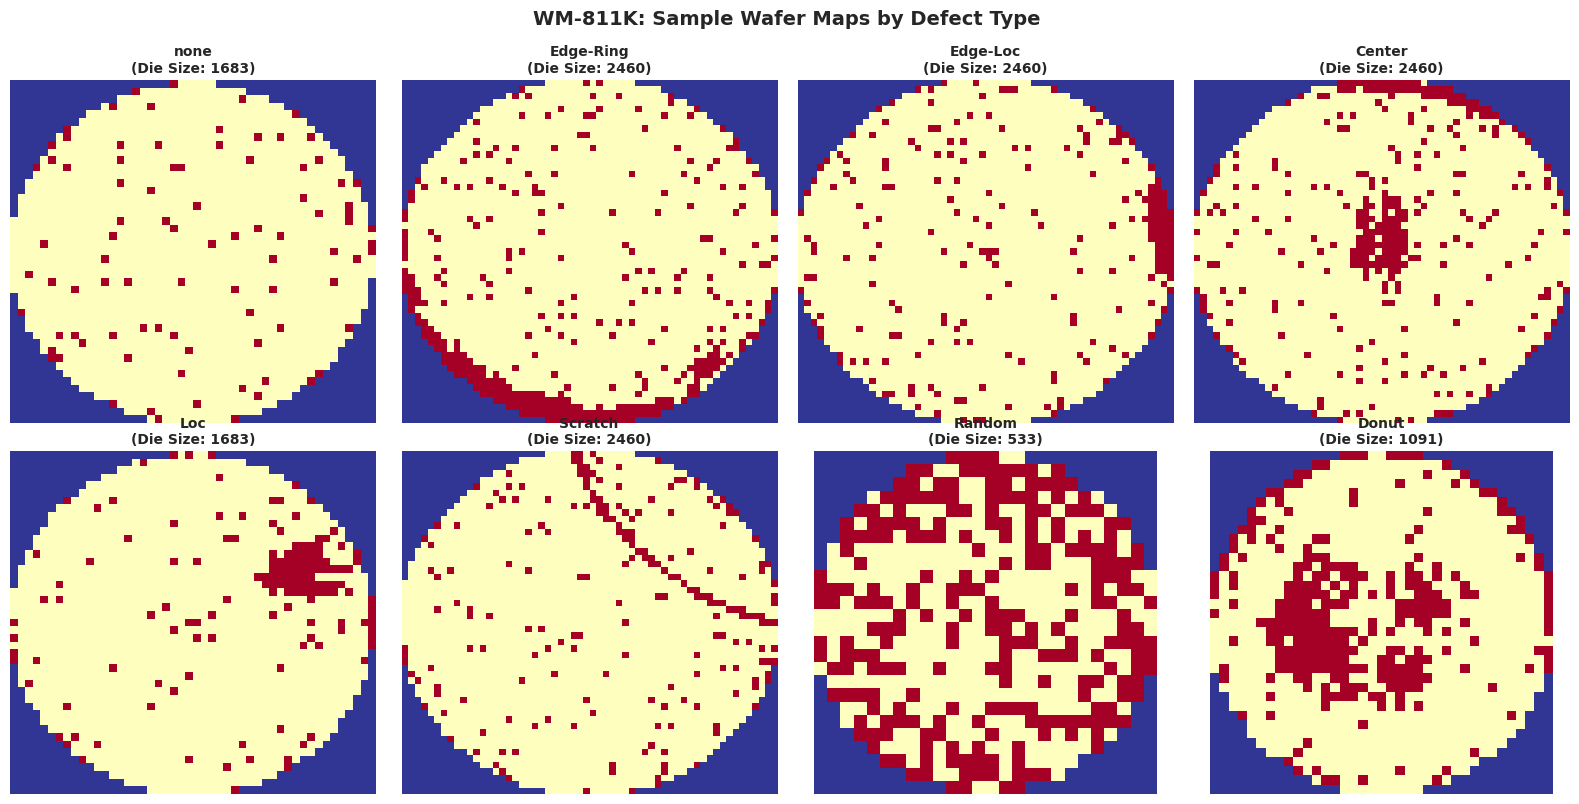

In [ ]:
# Visualize sample wafer maps for different failure types
defect_types = ['none', 'Edge-Ring', 'Edge-Loc', 'Center', 'Loc', 'Scratch', 'Random', 'Donut']

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, defect_type in enumerate(defect_types):
    # Get a sample for this defect type
    samples = data[data['failureType_clean'] == defect_type]
    if len(samples) == 0:
        axes[idx].text(0.5, 0.5, f'No {defect_type} found', ha='center', va='center')
        axes[idx].set_title(defect_type)
        axes[idx].axis('off')
        continue
    
    sample = samples.iloc[0]
    wafer_map = sample['waferMap']
    
    # Extract the wafer map array
    if isinstance(wafer_map, np.ndarray):
        # Flatten nested arrays if needed
        if wafer_map.ndim > 2:
            wafer_map = wafer_map[0] if len(wafer_map) > 0 else wafer_map
        
        axes[idx].imshow(wafer_map, cmap='RdYlBu_r', interpolation='nearest')
        axes[idx].set_title(f'{defect_type}\n(Die Size: {sample["dieSize"]:.0f})', 
                          fontsize=10, fontweight='bold')
        axes[idx].axis('off')
    else:
        axes[idx].text(0.5, 0.5, 'Cannot display', ha='center', va='center')
        axes[idx].set_title(defect_type)
        axes[idx].axis('off')

plt.suptitle('WM-811K: Sample Wafer Maps by Defect Type', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 7. Convert to Polars for Efficient Analysis

In [ ]:
# Convert to Polars (excluding array columns) — build directly for speed, no pyarrow needed
# Polars doesn't support 2D arrays (waferMap), so we only bring tabular columns
df_pl = pl.DataFrame({
    "dieSize": data["dieSize"].to_numpy(dtype=np.float64, copy=False),
    "lotName": data["lotName"].astype(str).to_numpy(),
    "waferIndex": data["waferIndex"].to_numpy(dtype=np.float64, copy=False),
    "failureType_clean": data["failureType_clean"].astype(str).to_numpy(),
})

print("Polars DataFrame created successfully!")
print(f"Shape: {df_pl.shape}")
print(f"\nSchema:")
print(df_pl.schema)
print(f"\nFirst 5 rows:")
df_pl.head()

Polars DataFrame created successfully!
Shape: (811457, 4)

Schema:
Schema({'dieSize': Float64, 'lotName': String, 'waferIndex': Float64, 'failureType_clean': String})

First 5 rows:


dieSize,lotName,waferIndex,failureType_clean
f64,str,f64,str
1683.0,"""lot1""",1.0,"""none"""
1683.0,"""lot1""",2.0,"""none"""
1683.0,"""lot1""",3.0,"""none"""
1683.0,"""lot1""",4.0,"""none"""
1683.0,"""lot1""",5.0,"""none"""


## 8. Advanced Analysis with Polars

In [ ]:
# Failure Type Analysis with Polars
print("Failure Type Analysis with Polars:")
failure_analysis = (
    df_pl
    .group_by('failureType_clean')
    .agg([
        pl.len().alias('count'),
        pl.col('dieSize').mean().alias('avg_die_size'),
        pl.col('dieSize').std().alias('std_die_size'),
        pl.col('waferIndex').mean().alias('avg_wafer_index')
    ])
    .sort('count', descending=True)
)

failure_analysis

Failure Type Analysis with Polars:


failureType_clean,count,avg_die_size,std_die_size,avg_wafer_index
str,u32,f64,f64,f64
"""none""",785938,1844.263695,2259.743269,12.957577
"""Edge-Ring""",9680,2601.081198,2704.873628,12.892665
"""Edge-Loc""",5189,1171.150703,891.917222,12.948738
"""Center""",4294,928.617606,1134.194816,13.383093
"""Loc""",3593,1351.021431,1708.588198,13.388533
"""Scratch""",1193,2010.430008,2540.39154,13.091366
"""Random""",866,1191.275982,1058.791796,12.550808
"""Donut""",555,1377.500901,616.760719,13.646847
"""Near-full""",149,821.456376,404.826497,13.322148


In [ ]:
# Lot analysis with Polars
print("Analysis by Lot (Top 10):")
lot_analysis = (
    df_pl
    .group_by('lotName')
    .agg([
        pl.len().alias('wafer_count'),
        pl.col('failureType_clean').filter(pl.col('failureType_clean') != 'none').len().alias('defect_count'),
        pl.col('dieSize').mean().alias('avg_die_size')
    ])
    .with_columns([
        (pl.col('defect_count') / pl.col('wafer_count') * 100).alias('defect_rate_%')
    ])
    .sort('wafer_count', descending=True)
    .head(10)
)

print(lot_analysis)

print(f"\n\nTotal unique lots: {df_pl['lotName'].n_unique()}")

Analysis by Lot (Top 10):
shape: (10, 5)
┌──────────┬─────────────┬──────────────┬──────────────┬───────────────┐
│ lotName  ┆ wafer_count ┆ defect_count ┆ avg_die_size ┆ defect_rate_% │
│ ---      ┆ ---         ┆ ---          ┆ ---          ┆ ---           │
│ str      ┆ u32         ┆ u32          ┆ f64          ┆ f64           │
╞══════════╪═════════════╪══════════════╪══════════════╪═══════════════╡
│ lot2491  ┆ 25          ┆ 0            ┆ 1075.0       ┆ 0.0           │
│ lot26134 ┆ 25          ┆ 0            ┆ 645.0        ┆ 0.0           │
│ lot45670 ┆ 25          ┆ 2            ┆ 1791.0       ┆ 8.0           │
│ lot40756 ┆ 25          ┆ 2            ┆ 776.0        ┆ 8.0           │
│ lot5608  ┆ 25          ┆ 0            ┆ 846.0        ┆ 0.0           │
│ lot22031 ┆ 25          ┆ 0            ┆ 4938.0       ┆ 0.0           │
│ lot13079 ┆ 25          ┆ 0            ┆ 533.0        ┆ 0.0           │
│ lot4778  ┆ 25          ┆ 0            ┆ 1285.16      ┆ 0.0           │
│ lot10184

## 9. Final Summary Statistics

In [ ]:
# Final Summary Statistics
print("="*60)
print("WM-811K DATASET SUMMARY")
print("="*60)

print(f"\n📊 Dataset Overview:")
print(f"   • Total wafer maps: {len(data):,}")
print(f"   • Total lots: {df_pl['lotName'].n_unique():,}")
print(f"   • Wafers per lot: ~{len(data) / df_pl['lotName'].n_unique():.1f}")
print(f"   • Wafer index range: {df_pl['waferIndex'].min():.0f} - {df_pl['waferIndex'].max():.0f}")

print(f"\n🎯 Die Size Statistics:")
print(f"   • Mean: {df_pl['dieSize'].mean():.1f}")
print(f"   • Median: {df_pl['dieSize'].median():.1f}")
print(f"   • Range: {df_pl['dieSize'].min():.0f} - {df_pl['dieSize'].max():.0f}")

print(f"\n🔴 Defect Statistics:")
total_defects = (df_pl['failureType_clean'] != 'none').sum()
defect_rate = total_defects / len(df_pl) * 100
print(f"   • Total defective wafers: {total_defects:,}")
print(f"   • Defect rate: {defect_rate:.2f}%")
print(f"   • Non-defective wafers: {(df_pl['failureType_clean'] == 'none').sum():,} ({100-defect_rate:.2f}%)")
print(f"   • Unique defect patterns: 8")

print(f"\n🏆 Top 3 Defect Types:")
top3 = failure_analysis.filter(pl.col('failureType_clean') != 'none').head(3)
for i, row in enumerate(top3.iter_rows(named=True), 1):
    print(f"   {i}. {row['failureType_clean']}: {row['count']:,} ({row['count']/len(df_pl)*100:.2f}%)")

print("\n" + "="*60)

WM-811K DATASET SUMMARY

📊 Dataset Overview:
   • Total wafer maps: 811,457
   • Total lots: 46,293
   • Wafers per lot: ~17.5
   • Wafer index range: 1 - 25

🎯 Die Size Statistics:
   • Mean: 1841.0
   • Median: 953.0
   • Range: 3 - 48099

🔴 Defect Statistics:
   • Total defective wafers: 25,519
   • Defect rate: 3.14%
   • Non-defective wafers: 785,938 (96.86%)
   • Unique defect patterns: 8

🏆 Top 3 Defect Types:
   1. Edge-Ring: 9,680 (1.19%)
   2. Edge-Loc: 5,189 (0.64%)
   3. Center: 4,294 (0.53%)



## Summary

### Key Findings:
- Dataset contains 811,457 wafer maps from 46,293 manufacturing lots
- 96.86% of wafers are defect-free
- 8 distinct defect patterns: Edge-Ring, Edge-Loc, Center, Loc, Scratch, Random, Donut, Near-full
- Defect patterns show clear visual characteristics in wafer maps

### Next Steps:
- Create reasoning labels

totoal_dies = 1683
defective_dies = 88
defect rate = 0.05228758169934641


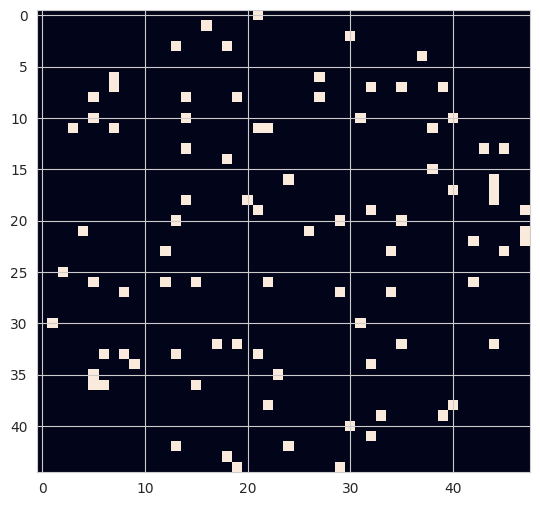

In [ ]:
sm_wafer_map = data.query("failureType_clean=='none'")['waferMap'].values[0]
plt.imshow((sm_wafer_map ==2))
defective_dies = sm_wafer_map ==2
print(f'totoal_dies = {np.sum(sm_wafer_map >0)}')
print(f'defective_dies = {np.sum(defective_dies)}')
print(f'defect rate = {np.sum(defective_dies)/np.sum(sm_wafer_map >0)}')





In [ ]:
# center of mass
y_co, x_co = np.where(defective_dies)
print(f'center of mass = {np.mean(y_co)}, {np.mean(x_co)}')


center of mass = 21.738636363636363, 23.954545454545453


In [ ]:
#| export
def compute_center_of_mass(defective_dies):
    "Compute the center of mass of the defective dies"
    if not np.any(defective_dies):
        return (0.0, 0.0)
    y_co, x_co = np.where(defective_dies)
    return (np.mean(y_co), np.mean(x_co))


In [ ]:
compute_center_of_mass(defective_dies)

(np.float64(21.738636363636363), np.float64(23.954545454545453))

In [ ]:

# spatial range
print(f'spatial range = height:{np.max(y_co)-np.min(y_co)}, width:{np.max(x_co)-np.min(x_co)}')
print(f'spatial area = {np.sum(defective_dies)}')


spatial range = height:44, width:46
spatial area = 88


In [ ]:
#| export
def compute_spatial_extent(
    defective_dies:np.ndarray
    )->tuple[float, float]:
    "Compute the spatial range of the defective dies"
    if not np.any(defective_dies):
        return {'width':0.0, 'height':0.0, 'area':0.0}
    y_co, x_co = np.where(defective_dies)
    return {'width':np.max(x_co)-np.min(x_co), 'height':np.max(y_co)-np.min(y_co), 'area':np.sum(defective_dies)}


In [ ]:
compute_spatial_extent(defective_dies)

{'width': np.int64(46), 'height': np.int64(44), 'area': np.int64(88)}

In [ ]:

# clustering
points = np.column_stack((x_co, y_co))
print(points.shape)
print(points)



(88, 2)
[[21  0]
 [16  1]
 [30  2]
 [13  3]
 [18  3]
 [37  4]
 [ 7  6]
 [27  6]
 [ 7  7]
 [32  7]
 [35  7]
 [39  7]
 [ 5  8]
 [14  8]
 [19  8]
 [27  8]
 [ 5 10]
 [14 10]
 [31 10]
 [40 10]
 [ 3 11]
 [ 7 11]
 [21 11]
 [22 11]
 [38 11]
 [14 13]
 [43 13]
 [45 13]
 [18 14]
 [38 15]
 [24 16]
 [44 16]
 [40 17]
 [44 17]
 [14 18]
 [20 18]
 [44 18]
 [21 19]
 [32 19]
 [47 19]
 [13 20]
 [29 20]
 [35 20]
 [ 4 21]
 [26 21]
 [47 21]
 [42 22]
 [47 22]
 [12 23]
 [34 23]
 [45 23]
 [ 2 25]
 [ 5 26]
 [12 26]
 [15 26]
 [22 26]
 [42 26]
 [ 8 27]
 [29 27]
 [34 27]
 [ 1 30]
 [31 30]
 [17 32]
 [19 32]
 [35 32]
 [44 32]
 [ 6 33]
 [ 8 33]
 [13 33]
 [21 33]
 [ 9 34]
 [32 34]
 [ 5 35]
 [23 35]
 [ 5 36]
 [ 6 36]
 [15 36]
 [22 38]
 [40 38]
 [33 39]
 [39 39]
 [30 40]
 [32 41]
 [13 42]
 [24 42]
 [18 43]
 [19 44]
 [29 44]]


In [ ]:
# clustering
distances = pdist(points)
print(distances)
# lower mean distance, more clustered
mean_distance = np.mean(distances)
print(f'mean distance = {mean_distance}')
max_possible = np.sqrt(np.sqrt(defective_dies.shape[0]**2 + defective_dies.shape[1]**2))
print(f'max possible = {max_possible}')

print((1 - (mean_distance/max_possible)))




[ 5.09901951  9.21954446  8.54400375 ...  1.41421356 11.04536102
 10.        ]
mean distance = 23.1746475551326
max possible = 8.111420134500735
-1.8570394790133777


In [ ]:
#| export
def compute_cluster_score(defective_dies):
    if not np.any(defective_dies):
        return 0.0

    
    # center of mass
    y_co, x_co = np.where(defective_dies)
    if len(y_co) <2:
        return 0.0
    points = np.column_stack((x_co, y_co))
    distances = pdist(points)
    mean_distance = np.mean(distances)
    max_possible = np.sqrt(np.sqrt(defective_dies.shape[0]**2 + defective_dies.shape[1]**2))
    return 1.0 - (mean_distance/max_possible)



In [ ]:
compute_cluster_score(defective_dies)

np.float64(-1.8570394790133777)

In [ ]:
# edge proximity
y_center, x_center = np.array(sm_wafer_map.shape) /2
# find wafer radius
valid_dies = sm_wafer_map >0
#plt.imshow(valid_dies)
#plt.xticks([])
#plt.yticks([])
y_co_, x_co_ = np.where(valid_dies)
print(y_co_, x_co_)
distances_to_center = np.sqrt((y_co_-y_center)**2 + (x_co_-x_center)**2)
print(distances_to_center)
print(np.max(distances_to_center))
print(f'wafer radius = {np.max(distances_to_center)}')
wafer_radius = np.max(distances_to_center)
# compute distance of defects to center
def_y, def_x = np.where(defective_dies)
print(def_y, def_x)
defect_distances = np.sqrt((def_y-y_center)**2 + (def_x-x_center)**2)
print(defect_distances)
# mean defect distance to center
mean_defect_radius = np.mean(defect_distances)
# proximity to edge
print(f'proximity to edge = {mean_defect_radius/wafer_radius}')
proximity_to_edge = mean_defect_radius/wafer_radius




















[ 0  0  0 ... 44 44 44] [21 22 23 ... 27 28 29]
[22.69911893 22.588714   22.52221126 ... 21.70829335 21.86892773
 22.07374005]
24.41823089414956
wafer radius = 24.41823089414956
[ 0  1  2  3  3  4  6  6  7  7  7  7  8  8  8  8 10 10 10 10 11 11 11 11
 11 13 13 13 14 15 16 16 17 17 18 18 18 19 19 19 20 20 20 21 21 21 22 22
 23 23 23 25 26 26 26 26 26 27 27 27 30 30 32 32 32 32 33 33 33 33 34 34
 35 35 36 36 36 38 38 39 39 40 41 42 42 43 44 44] [21 16 30 13 18 37  7 27  7 32 35 39  5 14 19 27  5 14 31 40  3  7 21 22
 38 14 43 45 18 38 24 44 40 44 14 20 44 21 32 47 13 29 35  4 26 47 42 47
 12 34 45  2  5 12 15 22 42  8 29 34  1 31 17 19 35 44  6  8 13 21  9 32
  5 23  5  6 15 22 40 33 39 30 32 13 24 18 19 29]
[22.69911893 22.94013949 21.36000936 22.38861318 20.40220576 22.61083811
 23.69071548 16.77050983 23.00543414 17.44276354 19.00657781 21.56965461
 23.90083681 17.61391495 15.33786165 14.80709289 22.74313083 16.00781059
 14.32654878 20.3039405  23.94263979 20.52437575 11.88486432 11.6

In [ ]:
#| export
def compute_edge_proximity(
    wafer_map:np.ndarray, # wafer map
    defective_dies:np.ndarray # defective dies (wafer map==2)
    )->float:
    "Compute the edge proximity of the defective dies"
    if not np.any(defective_dies):
        return 0.0

    # find wafer center
    y_center, x_center = np.array(wafer_map.shape) /2
    # find wafer radius
    valid_dies = wafer_map >0
    y_co_, x_co_ = np.where(valid_dies)
    distances_to_center = np.sqrt((y_co_-y_center)**2 + (x_co_-x_center)**2)
    wafer_radius = np.max(distances_to_center)
    # compute distance of defects to center
    def_y, def_x = np.where(defective_dies)
    defect_distances = np.sqrt((def_y-y_center)**2 + (def_x-x_center)**2)
    mean_defect_radius = np.mean(defect_distances)
    # proximity to edge
    return mean_defect_radius/wafer_radius


In [ ]:

compute_edge_proximity(sm_wafer_map, defective_dies)



np.float64(0.698930935511233)

In [ ]:
def analyze_spatial_pattern(
    wafer_map:np.ndarray, # wafer map
    ):
    "Analyze the spatial pattern of the wafer map"
    defective_dies = wafer_map ==2
    featurs = {
        'total_dies':np.sum(wafer_map>0),
        'defective_dies':np.sum(defective_dies),
        'defect_ratio':np.sum(defective_dies)/np.sum(wafer_map>0),
        'center_of_mass':compute_center_of_mass(defective_dies),
        'spatial_extent':compute_spatial_extent(defective_dies),
        'clustering_metric':compute_cluster_score(defective_dies),
        'edge_proximity':compute_edge_proximity(
            wafer_map=wafer_map, 
            defective_dies=defective_dies
            ),
    }
    return featurs


In [ ]:
wafer_features = analyze_spatial_pattern(sm_wafer_map)
wafer_features







{'total_dies': np.int64(1683),
 'defective_dies': np.int64(88),
 'defect_ratio': np.float64(0.05228758169934641),
 'center_of_mass': (np.float64(21.738636363636363),
  np.float64(23.954545454545453)),
 'spatial_extent': {'width': np.int64(46),
  'height': np.int64(44),
  'area': np.int64(88)},
 'clustering_metric': np.float64(-1.8570394790133777),
 'edge_proximity': np.float64(0.698930935511233)}

In [ ]:
defect_ratio = wafer_features['defect_ratio']
print(defect_ratio)







0.05228758169934641


In [ ]:
#| export
def _template_edge_ring(
    wafer_map:np.ndarray,  # wafer map
    features:dict # features after spatial analysis (analyze_spatial_pattern function)
    ) -> dict:
    defect_ratio = features['defect_ratio'] * 100
    edge_prox = features['edge_proximity']
        
    # Determine severity
    if defect_ratio < 10:
        severity_level = "Minor"
        yield_impact = "2-5%"
    elif defect_ratio < 30:
        severity_level = "Moderate" 
        yield_impact = "5-15%"
    else:
        severity_level = "Major"
        yield_impact = ">15%"
        
    return {
        'pattern_description': 'Edge-ring defect pattern detected.',
            
        'spatial_analysis': f'''Defects form a ring pattern around the wafer periphery. 
        Edge proximity metric: {edge_prox:.2f} (1.0 = pure edge pattern). 
        Approximately {defect_ratio:.1f}% of wafer dies are affected. 
        The defects show uniform azimuthal distribution around the wafer edge.''',
            
        'root_cause': '''This pattern is characteristic of temperature gradient issues 
        during thermal processing steps such as diffusion, oxidation, or annealing. 
        The wafer edge experiences different thermal conditions than the center due to 
        edge effects in the furnace. Possible specific causes include: (1) furnace 
        temperature profile deviation from specification, (2) inadequate temperature 
        ramping rates causing thermal stress, (3) edge heating element malfunction, 
        or (4) improper wafer positioning in carrier.''',
            
        'severity_assessment': f'''Severity: {severity_level}
        Estimated yield impact: {yield_impact}
        Economic impact: Edge dies typically represent 10-15% of total die count, 
        but their loss affects overall wafer yield and may trigger process holds 
        if percentage exceeds control limits.''',
            
        'recommended_action': '''Immediate actions:
        1. Verify furnace zone temperature calibration against specification
        2. Review and validate temperature ramp profiles  
        3. Inspect edge heating elements for damage, wear, or malfunction
        4. Check wafer positioning in furnace carrier/boat
        5. Monitor next 5-10 wafer lots for pattern persistence
        6. If pattern persists: schedule preventive maintenance on thermal processing equipment
        7. Consider process window adjustment if equipment is within specification''',
            
        'confidence': 0.92,
        'defect_type': 'Edge-Ring',
        'process_suspect': 'Thermal processing (furnace)'
    }

In [ ]:
_template_edge_ring(
    wafer_map=sm_wafer_map,
    features=wafer_features
)




{'pattern_description': 'Edge-ring defect pattern detected.',
 'spatial_analysis': 'Defects form a ring pattern around the wafer periphery. \n        Edge proximity metric: 0.70 (1.0 = pure edge pattern). \n        Approximately 5.2% of wafer dies are affected. \n        The defects show uniform azimuthal distribution around the wafer edge.',
 'root_cause': 'This pattern is characteristic of temperature gradient issues \n        during thermal processing steps such as diffusion, oxidation, or annealing. \n        The wafer edge experiences different thermal conditions than the center due to \n        edge effects in the furnace. Possible specific causes include: (1) furnace \n        temperature profile deviation from specification, (2) inadequate temperature \n        ramping rates causing thermal stress, (3) edge heating element malfunction, \n        or (4) improper wafer positioning in carrier.',
 'severity_assessment': 'Severity: Minor\n        Estimated yield impact: 2-5%\n      

In [ ]:
#| export
def _template_center(
    wafer_map:np.ndarray, # wafer map
    features:dict # features after spatial analysis (analyze_spatial_pattern function)
    ) -> dict:
    com_y, com_x = features['center_of_mass']
    center_y, center_x = np.array(wafer_map.shape) / 2
    centrality = 1.0 - (np.sqrt((com_y - center_y)**2 + (com_x - center_x)**2) / 
                       np.sqrt(center_y**2 + center_x**2))
    defect_ratio = features['defect_ratio'] * 100
        
    return {
        'pattern_description': 'Center defect cluster detected.',
            
            'spatial_analysis': f'''Defects are concentrated in the central region of the wafer. 
            Centrality metric: {centrality:.2f} (1.0 = perfect center). 
            Approximately {defect_ratio:.1f}% of wafer dies affected. 
            Defect cluster spatial extent: {features["spatial_extent"]["area"]} dies.''',
            
            'root_cause': '''Center clustering typically indicates issues with spin coating, 
            chemical vapor deposition (CVD), or other deposition processes that exhibit 
            radial non-uniformity. During spin coating, photoresist or other materials can 
            accumulate differently at the wafer center due to centrifugal force dynamics. 
            For CVD processes, gas flow patterns can cause center-to-edge variations. 
            Possible causes: (1) incorrect spin coating parameters (RPM, acceleration), 
            (2) coating material viscosity out of specification, (3) substrate surface 
            preparation issues, (4) CVD gas flow non-uniformity, or (5) plasma density 
            variation in etch/deposition.''',
            
            'severity_assessment': f'''Severity: Moderate to High
            Center region typically contains high-value or critical functionality dies in many 
            chip layouts. Estimated yield impact: 8-20% depending on product design and die 
            layout. The concentration of failures in center may indicate process capability 
            issues requiring attention.''',
            
            'recommended_action': '''Recommended actions:
            1. Verify spin coating process parameters (RPM, acceleration, duration)
            2. Check coating material viscosity and material age/shelf life
            3. Inspect spin chuck for contamination or wear
            4. Review substrate surface preparation and pre-clean procedures
            5. For CVD/Deposition: check gas flow rates and showerhead condition
            6. Test with fresh material batch to rule out material issues
            7. Consider designed experiment (DOE) to optimize center-to-edge uniformity''',
            
            'confidence': 0.88,
            'defect_type': 'Center',
            'process_suspect': 'Spin coating / Deposition'
        }


In [ ]:
_template_center(
    wafer_map=sm_wafer_map,
    features=wafer_features
)




{'pattern_description': 'Center defect cluster detected.',
 'spatial_analysis': 'Defects are concentrated in the central region of the wafer. \n            Centrality metric: 0.98 (1.0 = perfect center). \n            Approximately 5.2% of wafer dies affected. \n            Defect cluster spatial extent: 88 dies.',
 'root_cause': 'Center clustering typically indicates issues with spin coating, \n            chemical vapor deposition (CVD), or other deposition processes that exhibit \n            radial non-uniformity. During spin coating, photoresist or other materials can \n            accumulate differently at the wafer center due to centrifugal force dynamics. \n            For CVD processes, gas flow patterns can cause center-to-edge variations. \n            Possible causes: (1) incorrect spin coating parameters (RPM, acceleration), \n            (2) coating material viscosity out of specification, (3) substrate surface \n            preparation issues, (4) CVD gas flow non-unifor

In [ ]:
#| export
def _template_scratch(
    wafer_map:np.ndarray, # wafer map
    features:dict # features after spatial analysis (analyze_spatial_pattern function)
    ) -> dict:
    # Detect scratch orientation and length
    defect_mask = (wafer_map == 2)
    y_coords, x_coords = np.where(defect_mask)
        
    if len(y_coords) > 1:
        # Fit line to detect orientation
        coeffs = np.polyfit(x_coords, y_coords, 1)
        angle = np.arctan(coeffs[0]) * 180 / np.pi
        length = np.sqrt((np.max(x_coords) - np.min(x_coords))**2 + 
                        (np.max(y_coords) - np.min(y_coords))**2)
    else:
        angle = 0
        length = 0
        
    defect_count = features['defective_dies']
        
    return {
        'pattern_description': 'Linear scratch pattern detected.',
            
        'spatial_analysis': f'''Linear defect running across wafer at approximately 
        {angle:.1f} degrees. Pattern length: ~{length:.1f} dies. 
        Number of dies affected: {defect_count}. 
        The linear nature and orientation suggest mechanical contact during handling.''',
            
        'root_cause': '''Mechanical damage from improper wafer handling or equipment contact. 
        Linear scratches indicate physical contact during wafer transfer operations. 
        Based on the scratch orientation and typical wafer handling flows, this likely 
        occurred during: robot transfer, cassette loading/unloading, or contact with 
        process chamber components. Specific causes may include: (1) robot gripper 
        misalignment or damage, (2) cassette slot burrs or sharp edges, (3) transfer 
        chamber wall interference, or (4) improper wafer centering.''',
            
        'severity_assessment': '''Severity: High
        Mechanical scratches typically cause permanent damage to device structures. 
        Even shallow scratches can lead to electrical failures. All affected dies 
        are likely yield losses. Immediate corrective action required to prevent 
        additional wafer damage.''',
            
        'recommended_action': '''Immediate actions (URGENT):
        1. STOP: Halt wafer processing on affected equipment until inspection complete
        2. Inspect robot end effector for damage, misalignment, or foreign material
        3. Check all cassettes for burrs, sharp edges, or structural damage
        4. Review robot transfer alignment and calibration
        5. Examine transfer chambers for interference points
        6. Implement 100% wafer inspection for next lot
        7. Schedule preventive maintenance on handler/robot system
        8. Review and retrain operators on proper handling procedures''',
            
        'confidence': 0.95,
        'defect_type': 'Scratch',
        'process_suspect': 'Mechanical handling / Robot transfer'
    }


In [ ]:
_template_scratch(
    wafer_map=sm_wafer_map,
    features=wafer_features
)




{'pattern_description': 'Linear scratch pattern detected.',
 'spatial_analysis': 'Linear defect running across wafer at approximately \n        -2.9 degrees. Pattern length: ~63.7 dies. \n        Number of dies affected: 88. \n        The linear nature and orientation suggest mechanical contact during handling.',
 'root_cause': 'Mechanical damage from improper wafer handling or equipment contact. \n        Linear scratches indicate physical contact during wafer transfer operations. \n        Based on the scratch orientation and typical wafer handling flows, this likely \n        occurred during: robot transfer, cassette loading/unloading, or contact with \n        process chamber components. Specific causes may include: (1) robot gripper \n        misalignment or damage, (2) cassette slot burrs or sharp edges, (3) transfer \n        chamber wall interference, or (4) improper wafer centering.',
 'severity_assessment': 'Severity: High\n        Mechanical scratches typically cause permane

In [ ]:
#| export
def _template_random(
    wafer_map:np.ndarray, # wafer map
    features:dict # features after spatial analysis (analyze_spatial_pattern function)
    ) -> dict:
    defect_ratio = features['defect_ratio'] * 100
    defect_count = features['defective_dies']
    total_dies = features['total_dies']
        
    # Compute defect density
    wafer_area_cm2 = np.pi * (15/2)**2  # Assume 300mm wafer
    defect_density = defect_count / wafer_area_cm2
        
    return {
        'pattern_description': 'Random defect pattern detected.',
            
        'spatial_analysis': f'''Defects are randomly distributed across the wafer with 
        no systematic spatial pattern. Defect count: {defect_count} out of {total_dies} 
        total dies ({defect_ratio:.1f}%). Spatial randomness confirmed by statistical 
        analysis (clustering metric: {features["clustering_metric"]:.2f}, where 0.0 indicates 
        perfect random distribution).''',
            
        'root_cause': '''Random defect distribution suggests particle contamination or 
        sporadic equipment issues rather than systematic process failures. Unlike patterned 
        defects (edge-ring, center, etc.), random defects typically arise from: (1) airborne 
        particle contamination in cleanroom environment, (2) contamination in process chemicals 
        or gases, (3) intermittent equipment issues such as plasma arcing or pressure 
        fluctuations, (4) electrostatic discharge events, or (5) particulate shedding from 
        worn equipment components.''',
            
        'severity_assessment': f'''Severity: Moderate
        Current defect density: {defect_density:.2f} defects/cm². 
        Yield impact: ~{defect_ratio:.1f}%. 
        While random defects affect yield, they typically don't indicate catastrophic process 
        failure. However, if defect density exceeds control limits or shows increasing trend, 
        investigation is warranted to prevent yield degradation.''',
            
        'recommended_action': '''Recommended actions:
        1. Increase particle monitoring in cleanroom (particle counters)
        2. Check HEPA filter integrity and replacement schedule
        3. Test process chemical and gas purity
        4. Review recent equipment preventive maintenance logs
        5. Inspect equipment for particle shedding (worn seals, O-rings, etc.)
        6. If particle counts elevated: perform cleanroom air flow validation
        7. Monitor defect density trend over next 10-20 wafers
        8. Consider inline particle inspection to correlate defects with contamination events''',
            
        'confidence': 0.85,
        'defect_type': 'Random',
        'process_suspect': 'Particle contamination / Sporadic equipment issue'
    }
   

In [ ]:
_template_random(
    wafer_map=sm_wafer_map,
    features=wafer_features
)


{'pattern_description': 'Random defect pattern detected.',
 'spatial_analysis': 'Defects are randomly distributed across the wafer with \n        no systematic spatial pattern. Defect count: 88 out of 1683 \n        total dies (5.2%). Spatial randomness confirmed by statistical \n        analysis (clustering metric: -1.86, where 0.0 indicates \n        perfect random distribution).',
 'root_cause': 'Random defect distribution suggests particle contamination or \n        sporadic equipment issues rather than systematic process failures. Unlike patterned \n        defects (edge-ring, center, etc.), random defects typically arise from: (1) airborne \n        particle contamination in cleanroom environment, (2) contamination in process chemicals \n        or gases, (3) intermittent equipment issues such as plasma arcing or pressure \n        fluctuations, (4) electrostatic discharge events, or (5) particulate shedding from \n        worn equipment components.',
 'severity_assessment': "Sev

In [ ]:
#| export
def _template_donut(
    wafer_map:np.ndarray, # wafer map
    features:dict # features after spatial analysis (analyze_spatial_pattern function)
    ) -> dict:
    return {
        'pattern_description': 'Donut (ring) defect pattern detected.',
        'spatial_analysis': 'Ring-shaped defect pattern with clear center and edge regions.',
        'root_cause': 'Process uniformity issue, often related to etch or deposition gas flow patterns.',
        'severity_assessment': 'Moderate severity, indicates process control issue.',
        'recommended_action': 'Check gas flow showerhead, verify plasma uniformity, review process parameters.',
        'confidence': 0.87,
        'defect_type': 'Donut',
        'process_suspect': 'Plasma etch/deposition'
    }


In [ ]:
_template_donut(
    wafer_map=sm_wafer_map,
    features=wafer_features
)


{'pattern_description': 'Donut (ring) defect pattern detected.',
 'spatial_analysis': 'Ring-shaped defect pattern with clear center and edge regions.',
 'root_cause': 'Process uniformity issue, often related to etch or deposition gas flow patterns.',
 'severity_assessment': 'Moderate severity, indicates process control issue.',
 'recommended_action': 'Check gas flow showerhead, verify plasma uniformity, review process parameters.',
 'confidence': 0.87,
 'defect_type': 'Donut',
 'process_suspect': 'Plasma etch/deposition'}

In [ ]:
#| export
def _template_localized(
    wafer_map:np.ndarray, # wafer map
    features:dict # features after spatial analysis (analyze_spatial_pattern function)
    ) -> dict:
    return {
        'pattern_description': 'Localized defect cluster detected.',
        'spatial_analysis': f'Defects clustered in specific region. Clustering metric: {features["clustering_metric"]:.2f}',
        'root_cause': 'Localized contamination event or equipment hot spot.',
        'severity_assessment': 'Severity depends on cluster size and location.',
        'recommended_action': 'Identify contamination source, inspect equipment for localized issues.',
        'confidence': 0.83,
        'defect_type': 'Localized',
        'process_suspect': 'Contamination / Equipment hot spot'
    }


In [ ]:
_template_localized(
    wafer_map=sm_wafer_map,
    features=wafer_features
)


{'pattern_description': 'Localized defect cluster detected.',
 'spatial_analysis': 'Defects clustered in specific region. Clustering metric: -1.86',
 'root_cause': 'Localized contamination event or equipment hot spot.',
 'severity_assessment': 'Severity depends on cluster size and location.',
 'recommended_action': 'Identify contamination source, inspect equipment for localized issues.',
 'confidence': 0.83,
 'defect_type': 'Localized',
 'process_suspect': 'Contamination / Equipment hot spot'}

In [ ]:
#| export
def _template_edge_loc(
    wafer_map:np.ndarray, # wafer map
    features:dict # features after spatial analysis (analyze_spatial_pattern function)
    ) -> dict:
    return {
        'pattern_description': 'Edge-localized defect pattern detected.',
        'spatial_analysis': 'Defects concentrated at specific edge location, not uniform ring.',
        'root_cause': 'Localized edge handling issue or wafer positioning problem.',
        'severity_assessment': 'Moderate, affects edge dies in specific region.',
        'recommended_action': 'Check wafer positioning, inspect edge handling equipment.',
        'confidence': 0.86,
        'defect_type': 'Edge-Loc',
        'process_suspect': 'Wafer positioning / Edge handling'
    }


In [ ]:
_template_edge_loc(
    wafer_map=sm_wafer_map,
    features=wafer_features
)


{'pattern_description': 'Edge-localized defect pattern detected.',
 'spatial_analysis': 'Defects concentrated at specific edge location, not uniform ring.',
 'root_cause': 'Localized edge handling issue or wafer positioning problem.',
 'severity_assessment': 'Moderate, affects edge dies in specific region.',
 'recommended_action': 'Check wafer positioning, inspect edge handling equipment.',
 'confidence': 0.86,
 'defect_type': 'Edge-Loc',
 'process_suspect': 'Wafer positioning / Edge handling'}

In [ ]:
#| export
def _template_nearfull(
    wafer_map:np.ndarray, # wafer map
    features:dict # features after spatial analysis (analyze_spatial_pattern function)
    ) -> dict:
    return {
        'pattern_description': 'Near-full wafer defect pattern detected (catastrophic failure).',
        'spatial_analysis': f'Majority of wafer affected: {features["defect_ratio"]*100:.1f}% of dies defective.',
        'root_cause': 'Catastrophic process failure, major equipment malfunction, or severe contamination event.',
        'severity_assessment': 'CRITICAL - wafer is scrap, immediate investigation required.',
        'recommended_action': 'STOP processing, quarantine lot, immediate engineering investigation, review all recent process changes.',
        'confidence': 0.98,
        'defect_type': 'Near-full',
        'process_suspect': 'Catastrophic failure - multiple potential causes'
    }


In [ ]:
_template_nearfull(
    wafer_map=sm_wafer_map,
    features=wafer_features
)


{'pattern_description': 'Near-full wafer defect pattern detected (catastrophic failure).',
 'spatial_analysis': 'Majority of wafer affected: 5.2% of dies defective.',
 'root_cause': 'Catastrophic process failure, major equipment malfunction, or severe contamination event.',
 'severity_assessment': 'CRITICAL - wafer is scrap, immediate investigation required.',
 'recommended_action': 'STOP processing, quarantine lot, immediate engineering investigation, review all recent process changes.',
 'confidence': 0.98,
 'defect_type': 'Near-full',
 'process_suspect': 'Catastrophic failure - multiple potential causes'}

In [ ]:
#| export
def _template_none(
    wafer_map:np.ndarray, # wafer map
    features:dict # features after spatial analysis (analyze_spatial_pattern function)
    ) -> dict:
    return {
        'pattern_description': 'No defect pattern detected - wafer appears good.',
        'spatial_analysis': f'All dies operational. Total dies: {features["total_dies"]}',
        'root_cause': 'N/A - no defects present.',
        'severity_assessment': 'None - wafer meets quality specifications.',
        'recommended_action': 'Continue processing. Maintain current process parameters.',
            'confidence': 0.99,
            'defect_type': 'None',
            'process_suspect': 'N/A'
        }


In [ ]:
_template_none(
    wafer_map=sm_wafer_map,
    features=wafer_features
)

{'pattern_description': 'No defect pattern detected - wafer appears good.',
 'spatial_analysis': 'All dies operational. Total dies: 1683',
 'root_cause': 'N/A - no defects present.',
 'severity_assessment': 'None - wafer meets quality specifications.',
 'recommended_action': 'Continue processing. Maintain current process parameters.',
 'confidence': 0.99,
 'defect_type': 'None',
 'process_suspect': 'N/A'}

In [ ]:
def load_templates(
    ) -> dict:
    return {
        'Edge-Ring':_template_edge_ring,
        'Center':_template_center,
        'Donut':_template_donut,
        'Scratch':_template_scratch,
        'Localized':_template_localized,
        'Random':_template_random,
        'Edge-Loc':_template_edge_loc,
        'Near-full':_template_nearfull,
        'none':_template_none,
    }

In [ ]:
#| export

class ReasoningLabelGenerator:
    def __init__(self):
        self.templates = load_templates()

    def generate_reasoning_label(
        self, 
        wafer_map:np.ndarray, # wafer map
        defect_class:str # defect class
        ) -> dict:
        sp_features = analyze_spatial_pattern(wafer_map)

        template_func = self.templates.get(defect_class)
        if not template_func:
            raise ValueError(f"Invalid defect class: {defect_class}")

        reasoning_label = template_func(
            wafer_map=wafer_map,
            features=sp_features
        )
        return reasoning_label





In [ ]:
reasoning_label_generator = ReasoningLabelGenerator()
reasoning_label_generator.generate_reasoning_label(
    wafer_map=sm_wafer_map,
    defect_class='Edge-Ring'
)

{'pattern_description': 'Edge-ring defect pattern detected.',
 'spatial_analysis': 'Defects form a ring pattern around the wafer periphery. \n        Edge proximity metric: 0.70 (1.0 = pure edge pattern). \n        Approximately 5.2% of wafer dies are affected. \n        The defects show uniform azimuthal distribution around the wafer edge.',
 'root_cause': 'This pattern is characteristic of temperature gradient issues \n        during thermal processing steps such as diffusion, oxidation, or annealing. \n        The wafer edge experiences different thermal conditions than the center due to \n        edge effects in the furnace. Possible specific causes include: (1) furnace \n        temperature profile deviation from specification, (2) inadequate temperature \n        ramping rates causing thermal stress, (3) edge heating element malfunction, \n        or (4) improper wafer positioning in carrier.',
 'severity_assessment': 'Severity: Minor\n        Estimated yield impact: 2-5%\n      

In [ ]:
data

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,failureType_clean
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]],none
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]],none
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]],none
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]],none
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]],none
...,...,...,...,...,...,...,...
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]],Edge-Ring
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]],Edge-Loc
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]],Edge-Ring
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[],none


In [ ]:
import polars as pl
from tqdm.notebook import tqdm

# Use df_pl (Polars) for tabular columns; waferMap stays in pandas (Polars can't hold 2D arrays)
wafer_maps = data['waferMap'].values
defect_classes = df_pl['failureType_clean'].to_numpy()
wafer_ids = df_pl['waferIndex'].to_numpy()

gen = ReasoningLabelGenerator()

res_labels = []

for idx in tqdm(range(len(df_pl)), desc='Processing wafers'):
    wafer_map = wafer_maps[idx]
    defect_class = defect_classes[idx]
    try:
        reasoning_label = gen.generate_reasoning_label(
            wafer_map=wafer_map,
            defect_class=defect_class
        )
        reasoning_label['wafer_id'] = wafer_ids[idx]
        res_labels.append(reasoning_label)
    except ValueError:
        print(f"Invalid defect class: {defect_class}")

    if idx % 1000 == 0:
        print(f"Processed {idx} wafers")

res_df = pl.DataFrame(res_labels)


In [ ]:

# Use json module for row-oriented + pretty output (Polars API changed)
import json
with open('reasoning_labels.json', 'w') as f:
    json.dump(res_df.to_dicts(), f, indent=2)

print(f"\nGenerated {len(res_labels)} reasoning labels!")
print("\nSample reasoning:")
print(json.dumps(res_labels[0], indent=2))


Generated 811457 reasoning labels!

Sample reasoning:
{
  "pattern_description": "No defect pattern detected - wafer appears good.",
  "spatial_analysis": "All dies operational. Total dies: 1683",
  "root_cause": "N/A - no defects present.",
  "severity_assessment": "None - wafer meets quality specifications.",
  "recommended_action": "Continue processing. Maintain current process parameters.",
  "confidence": 0.99,
  "defect_type": "None",
  "process_suspect": "N/A",
  "wafer_id": 1.0
}
